# "20 Newsgroups" Classification

#### Some imports:

In [51]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import matplotlib as mpl


#### Load 20newsgroup data:

In [52]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

pprint(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


#### Vectorize data for classification

Now we vectorize the data using a term-frequency-times-inverse-document-frequency (TF-IDF) vectorizer. The  term frequency (TF)  

$$ \text{TF}_{t}(D):=\frac{n_t(D)+1}{\text{max}_{s\in D} n_t(D)+1}$$

measures the frequency $n_t(D)$ of a term  $t$ in a document $D$ relative to the largest such number in $D$.
The inverse document frequency (IDF) is defined by 

$$ \text{IDF}_{t}:=\log\left(\frac{N_D}{f_t}\right)+1, $$

where $N_{D}$ is the number of documents and $f_{t}$ is the number of documents that contain $t$. The TF-IDF measure is then simply 

$$ \text{TF-IDF}_{t}(D):=\text{TF}_{t}(D)\cdot\text{IDF}_{t}.$$

It measures the relevance of a term in a set of documents.

In [228]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
#vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectors_train = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)

print(vectors_train.shape, vectors_test.shape)

(2034, 189472) (1353, 189472)


We use a Naive Bayes Classifier (NBC) to classify data in a first step.

In [229]:
clf = MultinomialNB(alpha=.01)
clf.fit(vectors_train, newsgroups_train.target)
pred = clf.predict(vectors_test)

metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.7784200130921102

In [230]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))
        
show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: islam does religion atheism say just think don people god
comp.graphics: looking windows does program know file files image thanks graphics
sci.space: lunar earth shuttle just moon orbit launch like nasa space
talk.religion.misc: objective think just don christians bible christian people jesus god


In [63]:
print(newsgroups_test.data[107])


He is God.


He is God.


God granted you the gift of life whether you were sinner or saint.
 

The scientist creates the living creature to examine it, poke and prod it and
learn about its behaviour.  He will kill it if it becomes a threat.  For
example, let's say the scientist creates a Tyrannosaurus Rex and it breaks
free of its confines and starts devouring the population.  The scientist
would not hesitate in killing it.

God creates us to be His loving companions.  He knows whether we are true in 
our love for Him or not.  And He lets us know the consequences of rejecting Him.
God cannot abide by sin.  By rejecting God, a person becomes an enemy of God,
one that must be killed by Him.  Note:  I say that God and God alone is
worthy to be Judge, Jury and Executioner.  We are not called to carry out
such duties because we are not worthy.
 

God is God.  Who are we to question the Creator?  If you doubt God's doing
in certain situations, do you claim to know a better solution?  Would

### Gridsearch:

In [31]:
from sklearn.model_selection import GridSearchCV

categories = ['comp.os.ms-windows.misc','soc.religion.christian','misc.forsale','sci.med']

parameters = {'vect__max_df': (0.5, 0.75, 1.0), 
              'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': ['english', None], 
              'clf__C':[.1,1,10]
             }
              
def gs_cv(categories, parameters):
    
    newsgroups_train = fetch_20newsgroups(subset='train', 
                                          remove=('headers', 'footers', 'quotes'), 
                                          categories=categories)

    text_clf = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf', TfidfTransformer()), 
                         ('clf', LinearSVC())])
    
    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
    gs_clf = gs_clf.fit(newsgroups_train.data, newsgroups_train.target)
    
    return gs_clf.best_params_

In [32]:
gs_cv(categories, parameters)

{'clf__C': 10,
 'vect__max_df': 0.5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [45]:
def classify(categories, output=True, get_clf=False):
    
    newsgroups_train = fetch_20newsgroups(subset='train', 
                                          remove=('headers', 'footers', 'quotes'), 
                                          categories=categories)

    text_clf = Pipeline([('vect', CountVectorizer(max_df=.5, ngram_range=(1,2), stop_words='english')), 
                         ('tfidf', TfidfTransformer()), 
                         ('clf', LinearSVC(C=10))])
    _ = text_clf.fit(newsgroups_train.data, newsgroups_train.target)

    newsgroups_test = fetch_20newsgroups(subset='test', 
                                         remove=('headers', 'footers', 'quotes'), 
                                         categories=categories)
    
    predicted = text_clf.predict(newsgroups_test.data)
    accuracy = np.mean(predicted == newsgroups_test.target)
    
    if output == True:
        print("categories : ", categories)
        print("accuracy: ", accuracy) 
        print(metrics.classification_report(newsgroups_test.target, predicted, 
                                            target_names=newsgroups_test.target_names))
        
    if get_clf: return text_clf
    
    return accuracy
    

#### Thematisch sehr unterschiedliche Kategorien:

In [35]:
categories = ['comp.os.ms-windows.misc','soc.religion.christian','misc.forsale','sci.med']
classify(categories)

categories :  ['comp.os.ms-windows.misc', 'soc.religion.christian', 'misc.forsale', 'sci.med']
accuracy:  0.8891001267427123
                         precision    recall  f1-score   support

comp.os.ms-windows.misc       0.82      0.87      0.84       394
           misc.forsale       0.92      0.92      0.92       390
                sci.med       0.91      0.85      0.88       396
 soc.religion.christian       0.91      0.91      0.91       398

              micro avg       0.89      0.89      0.89      1578
              macro avg       0.89      0.89      0.89      1578
           weighted avg       0.89      0.89      0.89      1578



0.8891001267427123

#### Thematisch sehr ähnliche Kategorien:

In [36]:
categories = ['comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x']
classify(categories)

categories :  ['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']
accuracy:  0.7618135376756067
                          precision    recall  f1-score   support

 comp.os.ms-windows.misc       0.69      0.71      0.70       394
comp.sys.ibm.pc.hardware       0.73      0.74      0.74       392
   comp.sys.mac.hardware       0.78      0.79      0.79       385
          comp.windows.x       0.85      0.80      0.83       395

               micro avg       0.76      0.76      0.76      1566
               macro avg       0.76      0.76      0.76      1566
            weighted avg       0.76      0.76      0.76      1566



0.7618135376756067

#### Alle Kategorien:

In [37]:
classify(None)

categories :  None
accuracy:  0.703797132235794
                          precision    recall  f1-score   support

             alt.atheism       0.54      0.48      0.51       319
           comp.graphics       0.68      0.72      0.70       389
 comp.os.ms-windows.misc       0.64      0.63      0.64       394
comp.sys.ibm.pc.hardware       0.65      0.67      0.66       392
   comp.sys.mac.hardware       0.74      0.70      0.72       385
          comp.windows.x       0.82      0.72      0.77       395
            misc.forsale       0.72      0.80      0.76       390
               rec.autos       0.51      0.78      0.62       396
         rec.motorcycles       0.82      0.75      0.79       398
      rec.sport.baseball       0.84      0.81      0.83       397
        rec.sport.hockey       0.88      0.89      0.89       399
               sci.crypt       0.82      0.72      0.77       396
         sci.electronics       0.66      0.60      0.63       393
                 sci.med   

0.703797132235794

In [40]:
test_scores  = []

for i in range(2,20):
    test_scores.append(classify(newsgroups_train.target_names[:i], output=False))


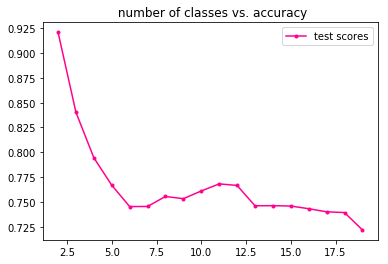

In [41]:
rng = range(2,20)
plt.plot(rng, test_scores, marker='.', color='xkcd:hot pink')
plt.legend(['test scores'])
plt.title(' number of classes vs. accuracy')
plt.savefig('filename.png', dpi=300)

In [49]:
Trump_tweet = "I will be strongly pushing Comprehensive \
                Background Checks with an emphasis on Mental Health. \
                Raise age to 21 and end sale of Bump Stocks! \
                Congress is in a mood to finally do something on this issue - I hope!"

categories = ['alt.atheism','comp.windows.x','talk.politics.guns']
clf_trump = classify(categories, output=False, get_clf=True)
print(clf_trump.predict([Trump_tweet]))

[2]


### Tremendous!